## Dividing cells

In [1]:
#import library
%matplotlib inline
from libsbml import readSBML
from cobra import io,flux_analysis
from cobra.core import Reaction,Metabolite
from IPython import display
import time

##### Modelling

In [2]:
#import sbml file
dividing_model = io.sbml.create_cobra_model_from_sbml_file("Models/PlantCoreMetabolism_v1_2_3.xml")

#only glucose as nutrient
dividing_model.reactions.get_by_id("GLC_tx").upper_bound = 0
dividing_model.reactions.get_by_id("GLC_tx").lower_bound = 0
dividing_model.reactions.get_by_id("Sucrose_tx").upper_bound = 0
dividing_model.reactions.get_by_id("Photon_tx").upper_bound = 0

#update phloem output to represent phloem uptake
temp = dividing_model.copy()
rxn = temp.reactions.get_by_id("Phloem_output_tx")
#print rxn.reaction
metlist = rxn.metabolites.keys()
for met in metlist:
    if met.id.__contains__("PROTON"):
        continue
    a = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-2*a})
c = rxn.metabolites.get(temp.metabolites.get_by_id("sSUCROSE_b"))
rxn.add_metabolites({temp.metabolites.get_by_id("sSUCROSE_b"):-1*c})
rxn.add_metabolites({temp.metabolites.get_by_id("SUCROSE_c"):c})
rxn.lower_bound = 0
rxn.upper_bound = 1000
#print rxn.reaction
#break
rxn.id = "Phloem_uptake_tx"
temp.reactions._generate_index()

#removed LEU and TRP from phloem because degradation pathway is incomplete and their fraction in 
# phloem is extremely minor
for Met in ["LEU_c","TRP_c","VAL_c","ILE_c","PHE_c","4_AMINO_BUTYRATE_c","TYR_c","GLN_c"]:
    met = temp.metabolites.get_by_id(Met)
    coeff = temp.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    temp.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})

dividing_model = temp.copy()

#Setting up maintenance
met=Metabolite("ATPNAPDH_maintenance_constraint")
dividing_model.reactions.get_by_id("ATPase_tx").add_metabolites({met:-1})
dividing_model.reactions.get_by_id("NADPHoxc_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("NADPHoxp_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("NADPHoxm_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("ATPase_tx").lower_bound = 0
dividing_model.reactions.get_by_id("ATPase_tx").upper_bound = 0


#Create a Protein_b metabolites
rxn = dividing_model.reactions.get_by_id("Biomass_tx")
for met in ["Ca_b","K_b","Mg_b"]:
    met = dividing_model.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
formula_dict = rxn.check_mass_balance()
met.formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
met.charge = formula_dict["charge"]*-1
rxn.add_metabolites({met:1})


#### Data processed from Rontein et al 2002

In [3]:
import pandas as pd
data={"sSUCROSE_b":0.00023384868704189686,"sCIT_b":8.668117044773994e-05,"sMAL_b":2.9579139027799716e-05,
      "FRU":0.0003876698255039685,"GLC":0.0006427015896873639}
temp1 = data.keys()
temp2 = list()
for t in temp1:
    temp2.append(data.get(t))
df = pd.DataFrame(data={"mets":temp1,"amount":temp2})
df = df[['mets', 'amount']]
df

,mets,amount
0,sCIT_b,0.000087
1,sSUCROSE_b,0.000234
2,GLC,0.000643
3,FRU,0.000388
4,sMAL_b,0.000030


In [4]:

#Addd dividing biomass
rxn = Reaction("Biomass_dividing")
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Cellulose_b"):-1*0.004167174993906135})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1*0.0002663702867671667})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Protein_b"):-1*0.0003168809295998026})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Starch_b"):-1*0.0011297601948076414})
dividing_model.add_reaction(rxn)

soluteTranslate={"sSUCROSE_b":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM",
                 "sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE",
                 "sALA_b":"L_ALPHA_ALANINE"}

for met2 in df["mets"]:
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    METB = Metabolite(met+"_b")
    if met=="HIS":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="MAL":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.7,aMETV:-0.3,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="CIT":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.5,aMETV:-0.5,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="FUM":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.92,aMETV:-0.08,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,METB:1})
        dividing_model.add_reaction(rxn)
    ##############
    METC = dividing_model.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,METB:1})
    dividing_model.add_reaction(rxn)
    
    rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
    rxn.add_metabolites({METB:-1*0.14*float(df["amount"][df["mets"]==met2])})
rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
rxn.lower_bound = 0
rxn.upper_bound = 1000

dividing_model.reactions.get_by_id("Biomass_dividing").objective_coefficient=1
#dividing_model.reactions.get_by_id("GLC_tx").objective_coefficient=-1

solution = flux_analysis.parsimonious.pfba(dividing_model)
print("Phloem uptake rate =")
print(dividing_model.reactions.get_by_id("Phloem_uptake_tx").x)


Phloem uptake rate =
5.56073491373


In [5]:
### set max growth rate based on Rontein 2002 
#max growth rate = 2 mg/ml = 2 g/L
backup_dividing = dividing_model.copy()
rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
formula_dict = rxn.check_mass_balance()
Biomass_MW2 = 0
for met in rxn.metabolites:
    Biomass_MW2=Biomass_MW2+(rxn.metabolites.get(met)*met.formula_weight*-1)
#max growth rate = 2 mg/ml = 2 g/L
rxn.upper_bound = 2.009/Biomass_MW2
rxn.lower_bound = 2.009/Biomass_MW2
solution = flux_analysis.parsimonious.pfba(dividing_model)
print("Phloem uptake rate =")
print(dividing_model.reactions.get_by_id("Phloem_uptake_tx").x)


cobra\core\metabolite.py:102 UserWarning: 17.2020450391 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra\core\metabolite.py:102 UserWarning: 25.9492553613 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra\core\metabolite.py:102 UserWarning: 5.7497158698 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra\core\metabolite.py:102 UserWarning: 4.9536245179 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra\core\metabolite.py:102 UserWarning: 0.1420323181 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)


Phloem uptake rate =
0.00965145809309


##### Estimation of maintenance cell model

Maintenance was estimated by increasing ATPase flux until Carbon conversion efficiency (CCE) = 70%

In [6]:
rxn = dividing_model.reactions.Phloem_uptake_tx
totC = 0
for met in rxn.metabolites:
    if "PROTON" in met.id:
        continue
    totC = totC + (met.elements["C"]*rxn.metabolites[met])
print totC

9.8517340867


In [7]:
Fraction = 0
i = 8
while Fraction < 0.3:
    i=i+0.1
    tempModel = dividing_model.copy()
    tempModel.reactions.get_by_id("ATPase_tx").lower_bound = i
    tempModel.reactions.get_by_id("ATPase_tx").upper_bound = i
    solution = flux_analysis.parsimonious.pfba(tempModel)
    Fraction = -1*solution.fluxes.get("CO2_tx")/(totC)
    print "NGAM ATPase flux ="+str(i)
    print "(1 - CCE) ="+str(Fraction)
    print "---------------------------"

print "Assumed maintenance cost, ATP ="
print tempModel.reactions.get_by_id("ATPase_tx").x

NGAM ATPase flux =8.1
(1 - CCE) =0.27149675422839914
---------------------------
NGAM ATPase flux =8.2
(1 - CCE) =0.2748453831674414
---------------------------
NGAM ATPase flux =8.3
(1 - CCE) =0.278194012106433
---------------------------
NGAM ATPase flux =8.4
(1 - CCE) =0.2815426410455396
---------------------------
NGAM ATPase flux =8.5
(1 - CCE) =0.28489126998461706
---------------------------
NGAM ATPase flux =8.6
(1 - CCE) =0.288239898923664
---------------------------
NGAM ATPase flux =8.7
(1 - CCE) =0.2915885278627114
---------------------------
NGAM ATPase flux =8.8
(1 - CCE) =0.29493715680178345
---------------------------
NGAM ATPase flux =8.9
(1 - CCE) =0.2982857857408292
---------------------------
NGAM ATPase flux =9.0
(1 - CCE) =0.3016344146798591
---------------------------
Assumed maintenance cost, ATP =
9.0


Constraining maintenance cost

In [8]:
backup_dividing2 = dividing_model.copy()
dividing_model.reactions.get_by_id("ATPase_tx").lower_bound = 9
dividing_model.reactions.get_by_id("ATPase_tx").upper_bound = 9
solution = flux_analysis.parsimonious.pfba(dividing_model)

#### Introduce osmotic cosntraints to force vacuolar accumulation

In [9]:
from studyFunctions import estimateVcell
import math

#Beauvoit et al data
T = 5
Vv = 0.853*(1-(math.e**((-2293-(T*24*60))/10633)))
Vc = (0.933 - Vv)/1.13

In [10]:
df

,mets,amount
0,sCIT_b,0.000087
1,sSUCROSE_b,0.000234
2,GLC,0.000643
3,FRU,0.000388
4,sMAL_b,0.000030


In [11]:
dividing_model2 = dividing_model.copy()
#Setting up osmotic constraints
#solutes=["SUCROSE","MAL","NITRATE","AMMONIUM","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM","MGII","KI","CAII"]
#solutes=["SUCROSE","MAL","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM"]
#solutes=["SUCROSE","GLC","FRU"]
soluteTranslate={"sSUCROSE_b":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}
VO = Metabolite("VO",name="vacuolar osmolytes")
VC = Metabolite("VC",name="vacuolar charge")
CO = Metabolite("CO",name="cytosolic osmolytes")
CC = Metabolite("CC",name="cytosolic charge")


for met2 in df["mets"]:
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    if met=="HIS":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:METV.charge,VO:1})
    elif met=="MAL":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="CIT":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="FUM":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:METV.charge,VO:1})
    ##############
    METC = dividing_model.metabolites.get_by_id(met+"_c")
    rxn = dividing_model2.reactions.get_by_id(met+"_c_biomass")
    rxn.add_metabolites({CC:METC.charge,CO:1})
    

for met in ["NITRATE","AMMONIUM","MGII","KI","CAII"]:
    METB = Metabolite(met+"_b")
    METV = dividing_model2.metabolites.get_by_id(met+"_v")
    rxn = Reaction(met+"_v_biomass")
    rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
    dividing_model2.add_reaction(rxn)
    
    METC = dividing_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    dividing_model2.add_reaction(rxn)
    
    rxn = Reaction(met+"_b_biomass")
    rxn.add_metabolites({METB:-1})
    dividing_model2.add_reaction(rxn)

rxn = Reaction("VacCytRatio")
WO = Metabolite("TotalSolute")
rxn.add_metabolites({CO:-1,VO:-1*(Vv/Vc),WO:1+(Vv/Vc)})
rxn.lower_bound = 0
rxn.upper_bound = 1000
dividing_model2.add_reaction(rxn)

rxn = Reaction("TotalSoluteConstraint")
rxn.add_metabolites({WO:-1})
rxn.lower_bound = 0
rxn.upper_bound = 1000
dividing_model2.add_reaction(rxn)

In [12]:
dividing_model2.reactions.get_by_id("ATPase_tx").lower_bound = 9
dividing_model2.reactions.get_by_id("ATPase_tx").upper_bound = 9
solution = flux_analysis.parsimonious.pfba(dividing_model2)
print("Phloem uptake rate =")
print("\t= "+str(dividing_model2.reactions.get_by_id("Phloem_uptake_tx").x)+" mmol/mL/day")
print("\t= "+str(dividing_model2.reactions.get_by_id("Phloem_uptake_tx").x*totC*12)+" mgC/mL/day")



Phloem uptake rate =
	= 0.325832744612 mmol/mL/day
	= 38.5202106798 mgC/mL/day


In [13]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"DividingFluxes_PhloemInput.csv",dividing_model2)

#### Data to generate flux map

In [14]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c","SUCROSE_v","FRU_c",
        "FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c","GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c",
        "PHOSPHO_ENOL_PYRUVATE_p","PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = dividing_model2.metabolites.get_by_id(met)
    R = dividing_model2.reactions.get_by_id("Phloem_uptake_tx")
    Cnum_std = totC
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
GLC_c_biomass	-0.00182025158253
Phloem_uptake_tx	0.506519864065
GLUCOKIN_RXN_c	-0.504699612483
-----
GLC_p
-----
GLC_6_P_c
G6P_Pi_pc	9.04576501946
PHOSPHOGLUCMUT_RXN_c	4.92761377696
PGLUCISOM_RXN_c	3.78620379572
GLUCOKIN_RXN_c	0.504699612483
GLU6PDEHYDROG_RXN_c	-18.2642822046
-----
GLC_6_P_p
PGLUCISOM_RXN_p	18.2642822046
G6P_Pi_pc	-9.04576501946
PHOSPHOGLUCMUT_RXN_p	-0.0736131351226
GLU6PDEHYDROG_RXN_p	-9.14490405004
-----
Cellulose_b
Cellulose_biomass	0.372811386552
Biomass_dividing	-0.1622286537
AraCore_Biomass_tx	-0.210582732853
-----
SUCROSE_c
Phloem_uptake_tx	10.7092771245
SUCROSE_SYNTHASE_RXN_c	-10.692065218
SUCROSE_c_biomass	-0.00254905257462
SUCROSE_PROTON_vc	-0.00336522418208
sSUCROSE_biomass	-0.011297629751
-----
SUCROSE_v
SUCROSE_PROTON_vc	0.00336522418208
3_PERIOD_2_PERIOD_1_PERIOD_48_RXN_v	-0.00336522418208
-----
FRU_c
FRUCTOKINASE_RXN_c	-5.92448218072
Phloem_uptake_tx	0.578879844646
SUCROSE_SYNTHASE_RXN_c	5.34603260899
FRU_c_biomass	-0.000430272910161
-----
FR

In [15]:
R = dividing_model2.reactions.get_by_id("Phloem_uptake_tx")
Cnum_std = totC
for rxn in dividing_model2.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([dividing_model2.metabolites.get_by_id("CC"),dividing_model2.metabolites.get_by_id("VC"),dividing_model2.metabolites.get_by_id("VO"),dividing_model2.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
CIT_b
CIT_v_biomass	0.00047243126206
Biomass_dividing	-0.00047243126206
-----
SUCROSE_b
SUCROSE_c_biomass	0.00254905257462
Biomass_dividing	-0.00254905257462
-----
GLC_b
GLC_c_biomass	0.00182025158253
Biomass_dividing	-0.00350286367357
GLC_v_biomass	0.00168261209104
-----
FRU_b
FRU_c_biomass	0.000430272910161
Biomass_dividing	-0.0021128850012
FRU_v_biomass	0.00168261209104
-----
MAL_b
Biomass_dividing	-0.000107475167593
MAL_v_biomass	0.000107475167593
-----
NITRATE_b
-----
AMMONIUM_b
AMMONIUM_v_biomass	0.000242523305419
AMMONIUM_b_biomass	-0.000242523305419
-----
MGII_b
-----
KI_b
-----
CAII_b


### Estimating ATP cost of protein, lipid, cellulose and starch biosynthesis

In [16]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("Protein_b"):-1})
rxn.lower_bound = dividing_model2.reactions.get_by_id("Biomass_tx").x
rxn.upper_bound = dividing_model2.reactions.get_by_id("Biomass_tx").x
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("protein")
dividing_model3.reactions.get_by_id("ATPase_tx").x

protein


-0.01760510044814849

In [17]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0

#removed AA from phloem because their degradation pathway is incomplete and their fraction in 
# phloem is relatively minor
for Met in ["HIS_c",]:
    met = dividing_model3.metabolites.get_by_id(Met)
    coeff = dividing_model3.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    dividing_model3.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})
#Add NH4 and SO4 escape mechanism
dividing_model3.reactions.NH4_ec.lower_bound = -1000
dividing_model3.reactions.SO4_ec.lower_bound = -1000

rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1})
rxn.lower_bound = dividing_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
rxn.upper_bound = dividing_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("lipid")
dividing_model3.reactions.get_by_id("ATPase_tx").x

lipid


-0.012542443525589279

In [18]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0

#removed AA from phloem because their degradation pathway is incomplete and their fraction in 
# phloem is relatively minor
for Met in ["HIS_c",]:
    met = dividing_model3.metabolites.get_by_id(Met)
    coeff = dividing_model3.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    dividing_model3.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})
#Add NH4 and SO4 escape mechanism
dividing_model3.reactions.NH4_ec.lower_bound = -1000
dividing_model3.reactions.SO4_ec.lower_bound = -1000

rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("Cellulose_b"):-1})
rxn.lower_bound = abs(dividing_model2.reactions.get_by_id("Cellulose_biomass").x)
rxn.upper_bound = abs(dividing_model2.reactions.get_by_id("Cellulose_biomass").x)
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("cellulose")
dividing_model3.reactions.get_by_id("ATPase_tx").x

cellulose


-0.03031608171589141

In [19]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0

#removed AA from phloem because their degradation pathway is incomplete and their fraction in 
# phloem is relatively minor
for Met in ["HIS_c",]:
    met = dividing_model3.metabolites.get_by_id(Met)
    coeff = dividing_model3.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    dividing_model3.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})
#Add NH4 and SO4 escape mechanism
dividing_model3.reactions.NH4_ec.lower_bound = -1000
dividing_model3.reactions.SO4_ec.lower_bound = -1000

rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("STARCH_p"):-1})
rxn.lower_bound = abs(dividing_model2.reactions.get_by_id("Starch_biomass").x)
rxn.upper_bound = abs(dividing_model2.reactions.get_by_id("Starch_biomass").x)
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("starch")
dividing_model3.reactions.get_by_id("ATPase_tx").x

starch


-0.008864895056071801

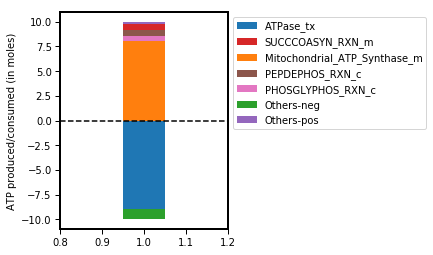

In [20]:
from studyFunctions import generateATPbudget

generateATPbudget(dividing_model2,solution.fluxes,outfile="ATP_budget_dividing.csv",
                  show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="",colourDict={})

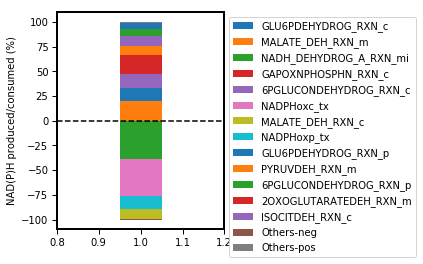

In [21]:
from studyFunctions import generateNADHNADPHbudget

generateNADHNADPHbudget(dividing_model2,solution.fluxes,outfile="NADPHbudget_dividing",
                        show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

In [22]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"DividingFluxes",dividing_model2)

## Expanding cell - 2

In [23]:
#Estimate volume of cell wall in a cell
def estimateVcellwallSample(Vcell):
    #Vcell                           #unit = m3
    #cell wall thickness = 100 nm according to figure 19-68, https://www.ncbi.nlm.nih.gov/books/NBK26928/
    b=100*(10**-9)                   #unit = m
    y = (8*(b**3))+(6*(Vcell**(2.0/3))*b)-(12*(Vcell**(1.0/3))*(b**2))
    return y

#Esimate cellulose content
def celluloseLevels(Vcell,Ncell):
    p_cellulose = 1.54*(10**6)              # unit = g/m3
    x = estimateVcellwallSample(Vcell)      # unit = m3/cell
    y = x*p_cellulose                       # unit = g/cell
    z = (y/180.16)*(10**6)*Ncell            # unit = umol/culture
    return z

#Estimate cell membrane of a cell
def estimateVcellmembrane(Vcell):
    #Vcell                       #unit = m3
    #cell wall thickness = 100 nm according to figure 19-68, https://www.ncbi.nlm.nih.gov/books/NBK26928/
    b=100*(10**-9)	
    #cell membrane thickness = 10 nm according to https://hypertextbook.com/facts/2001/JenniferShloming.shtml (see Hine, Robert. "Membrane." The Facts on File Dictionary of Biology. 3rd ed. New York: Checkmark, 1999: 198.)
    #c = 10*(10**-9)				#unit = m
    #cell membrane thickness = 4 nm BioNumbers
    c = 4*(10**-9)				#unit = m
    y = (8*(c**3))+(6*(Vcell**(2.0/3))*c)-(24*(b**2)*c)-(12*(c**2)*((Vcell**(1.0/3))-(2*b)))-(24*(Vcell**(1.0/3))*b*c)	#unit = m3
    return y

#Esimate phospholipid content
def phospholipidLevels(Vcell,Ncells):
    #dipalmitoyl phosphatidate  density = 0.928*(10**6)
    p_PA = 0.928*(10**6)              # unit = g/m3
    mw_PA = 646.88                    # unit = g/mol
    x = estimateVcellmembrane(Vcell)  # unit = m3/cell
    y = x*p_PA                        # unit = g/cell
    z = (y/mw_PA)*(10**6)*Ncells*(100.0/11.75)      # unit = umol/culture
    return z


#Estimate total protein content
def estimateProteinContent(Vcell,Ncell,ProtConc):
    #Vcell                           # unit = m3
    Vcyt = Vcell*(50.0/100.0)        # unit = m3/cell
    Vcyt_total = Vcyt*Ncell          # unit = m3/culture
    y = ProtConc*Vcyt_total*(10**6)        # unit = umol/culture
    return y



In [24]:

import math

#Assuming cell number = 0.1 to 0.4 million
Ncells = 1.45*(10**9)

#Beauvoit et al data
Vcell1 = estimateVcell(26)
Vcell2 = estimateVcell(27)
T = 26.63
Vcell1 = ((0.02894333/(0.00760074+(math.e**(-0.18324543*T))))-0.03277816)*(10**-12) # units = m3
Vcell_dash = (0.005303727*(math.e**(-0.18324543*T)))/((0.00760074+(math.e**(-0.18324543*T)))**2)
Vv = 0.853*(1-(math.e**((-2293-(T*24*60))/10633)))
Vc = (0.933 - Vv)/1.13

Processing GLC...


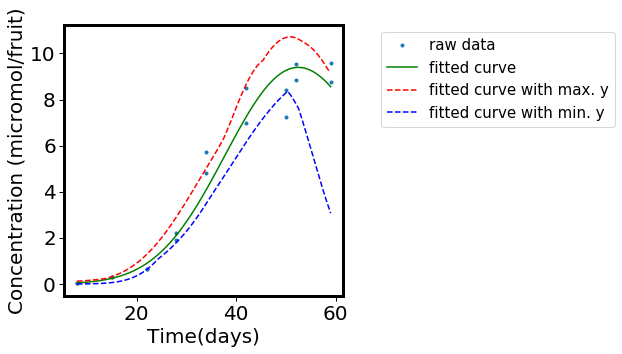

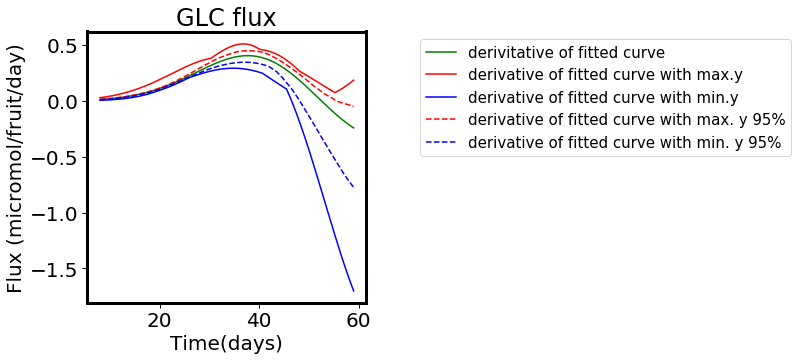

Processing FRU...


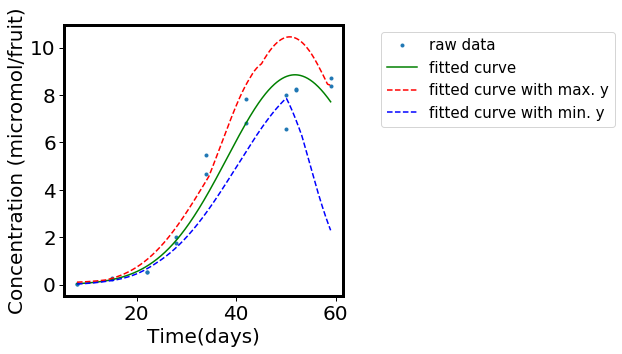

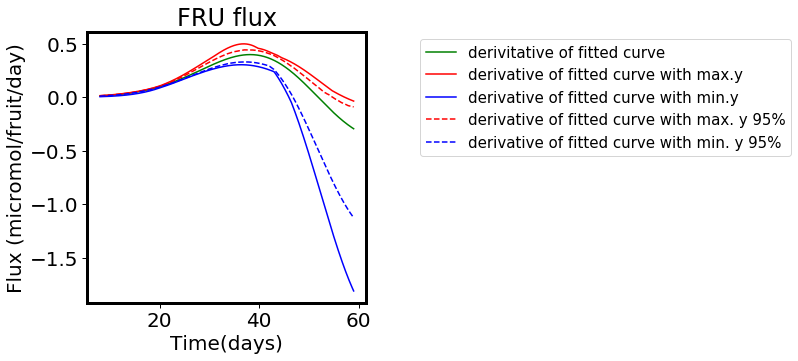

Processing SUC...


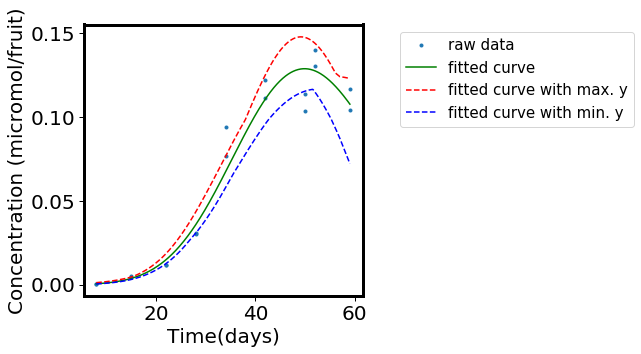

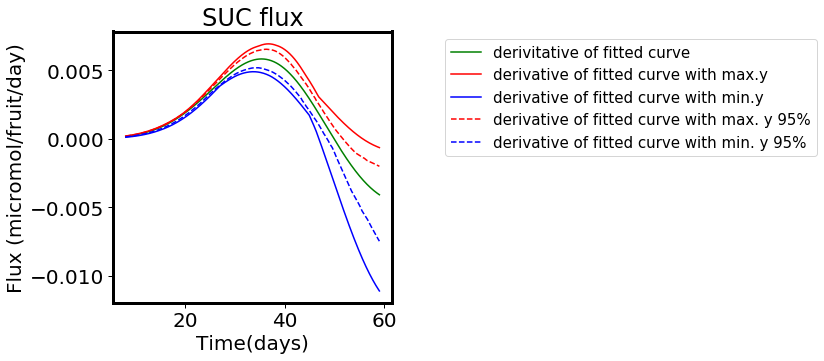

Processing MAL...


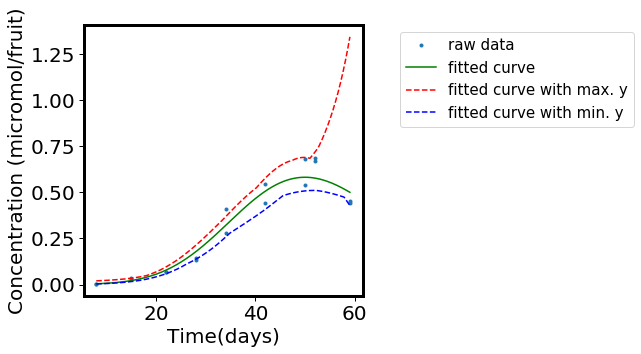

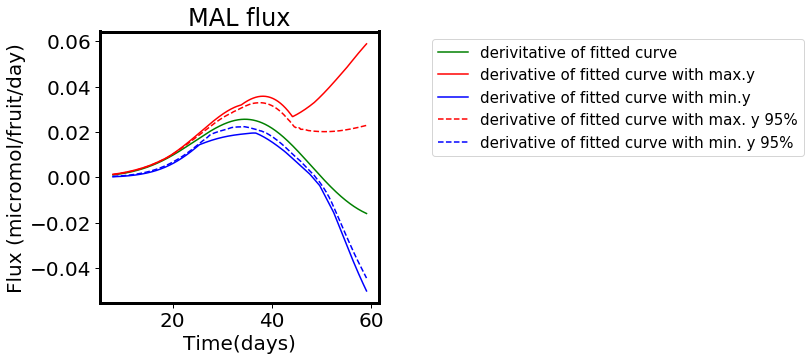

Processing CIT...


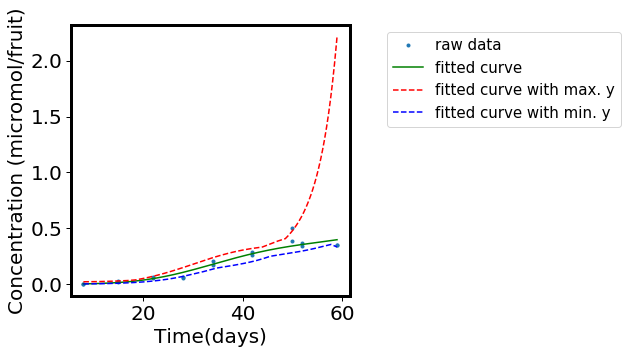

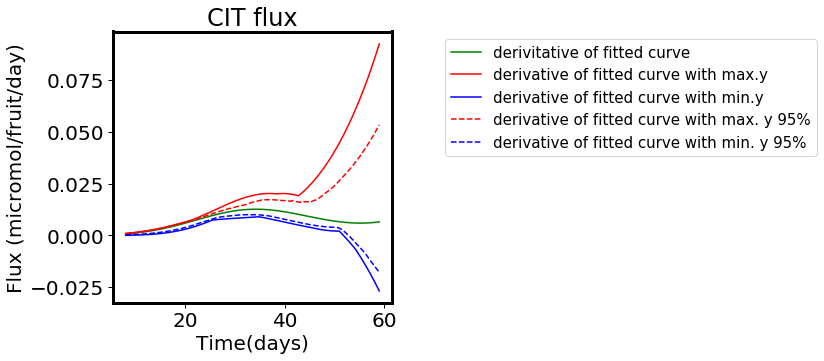

Processing L_ALPHA_ALANINE...


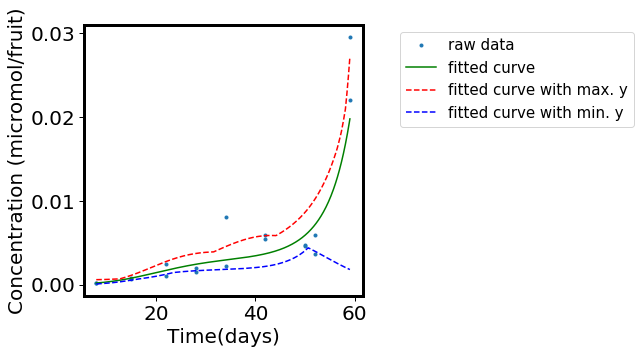

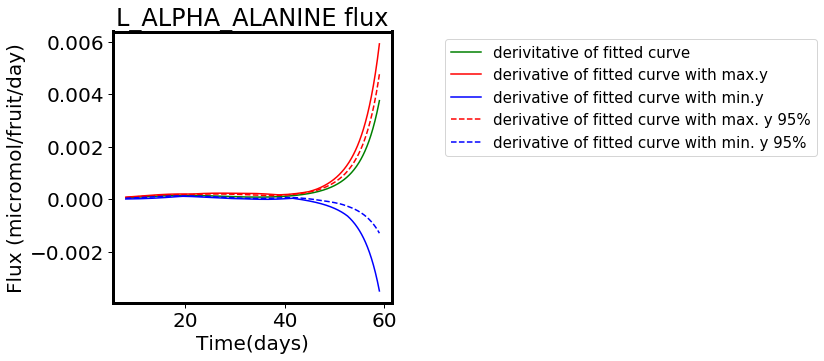

Processing ASN...


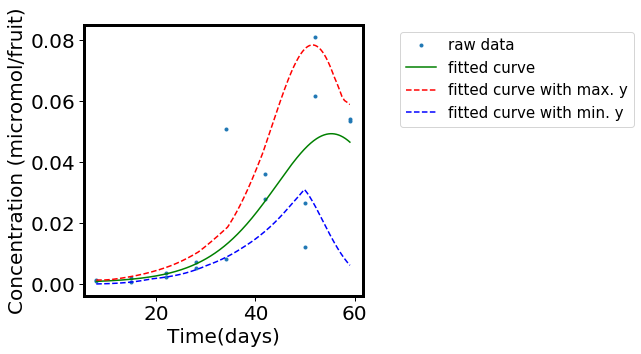

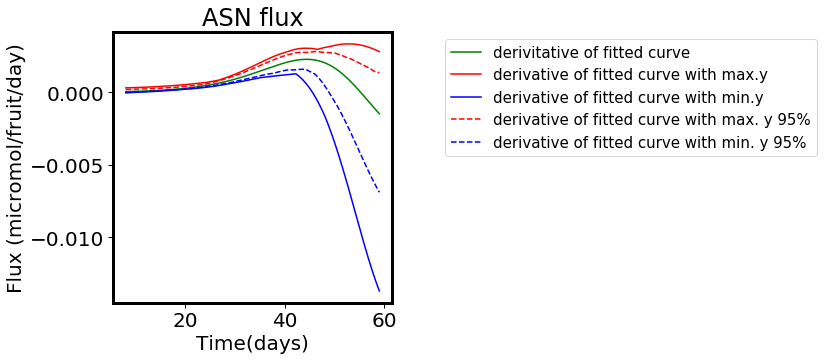

Processing L_ASPARTATE...


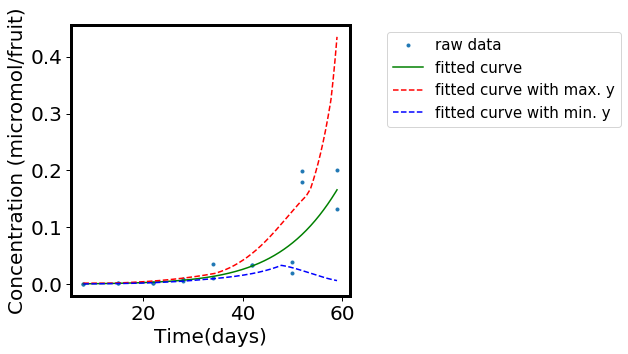

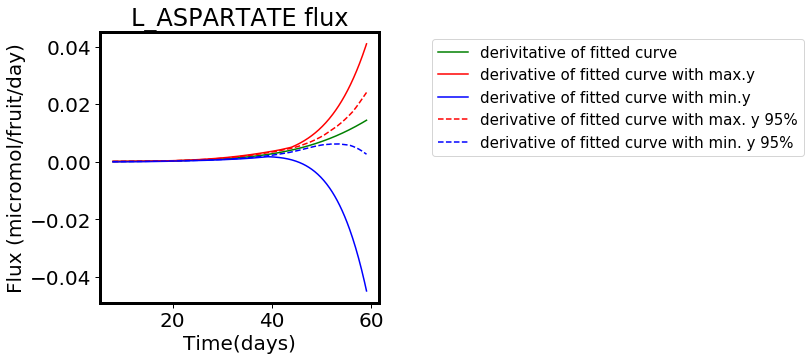

Processing GABA...


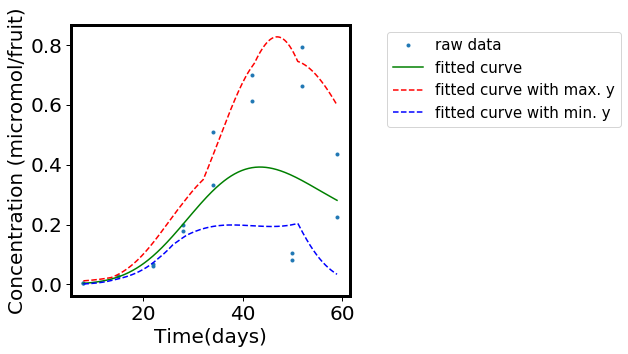

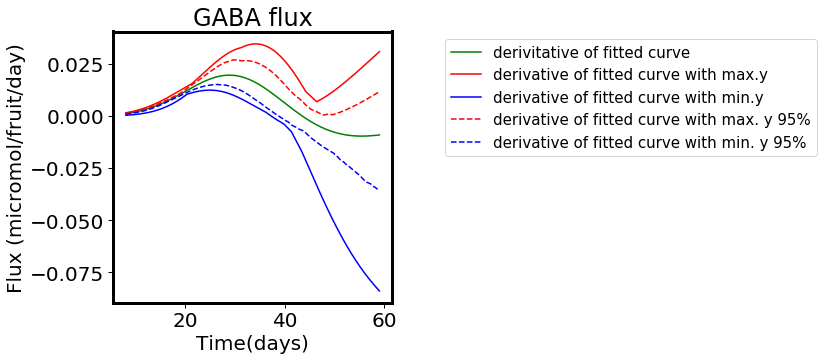

Processing GLT...


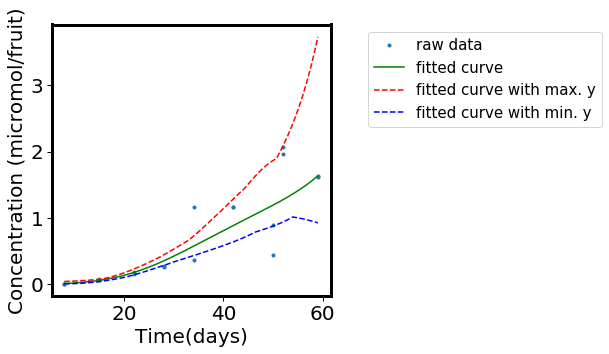

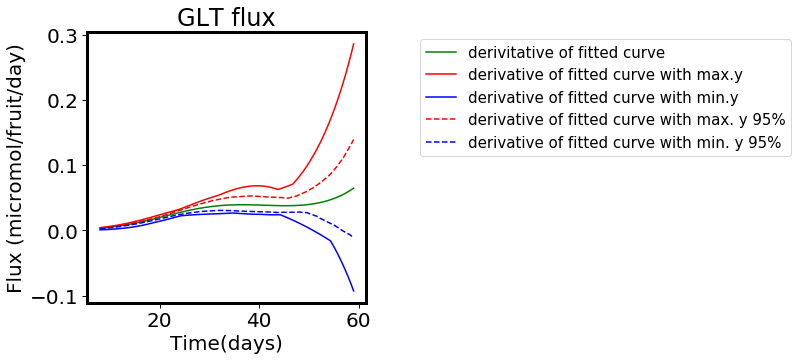

Processing GLN...


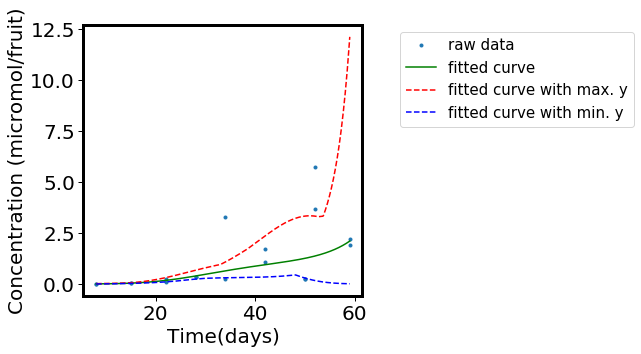

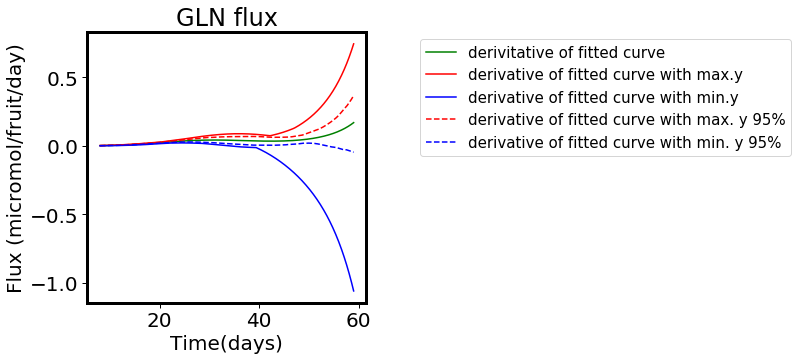

Processing GLY...


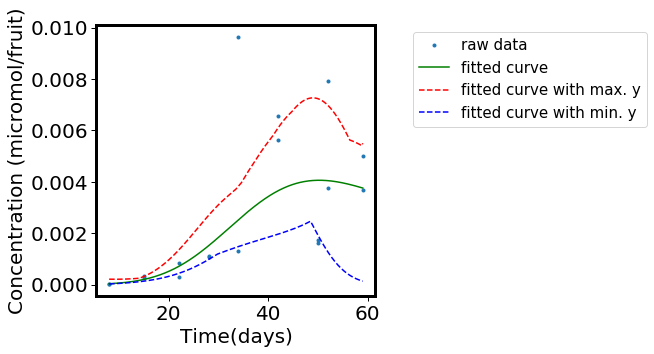

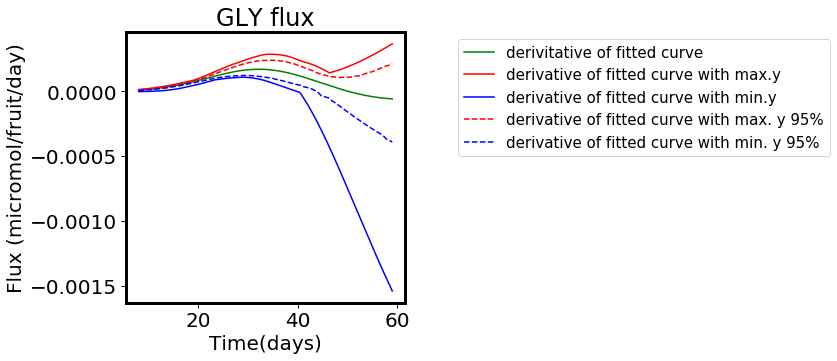

Processing ILE...


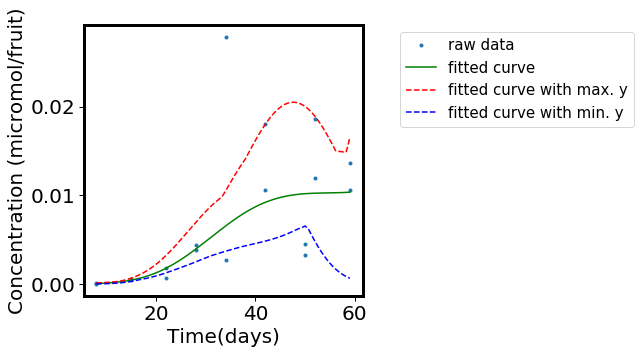

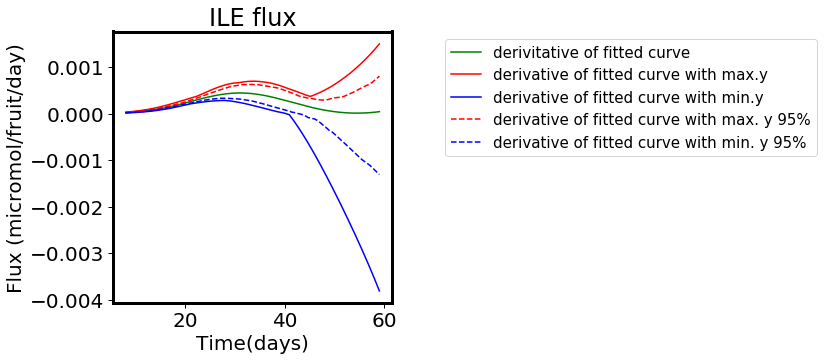

Processing LYS...


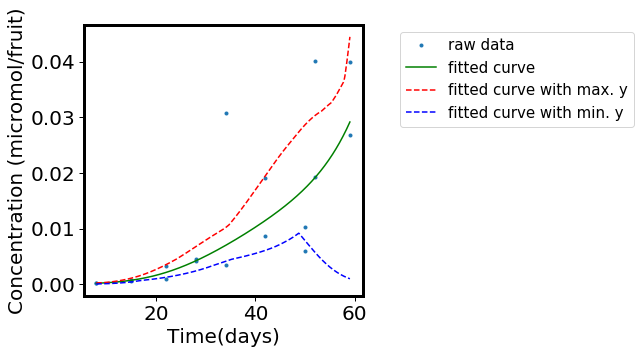

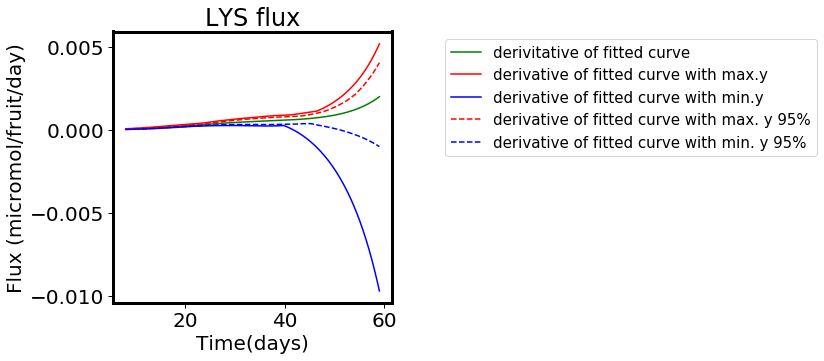

Processing MET...


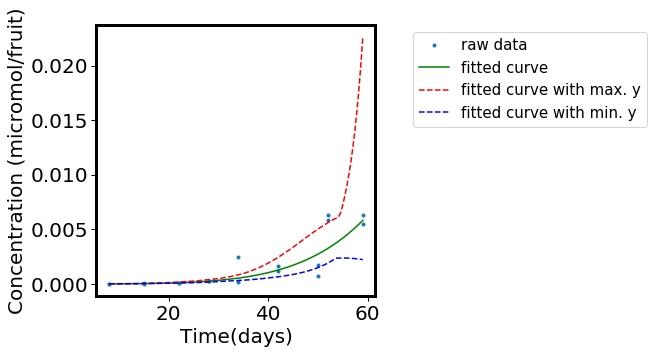

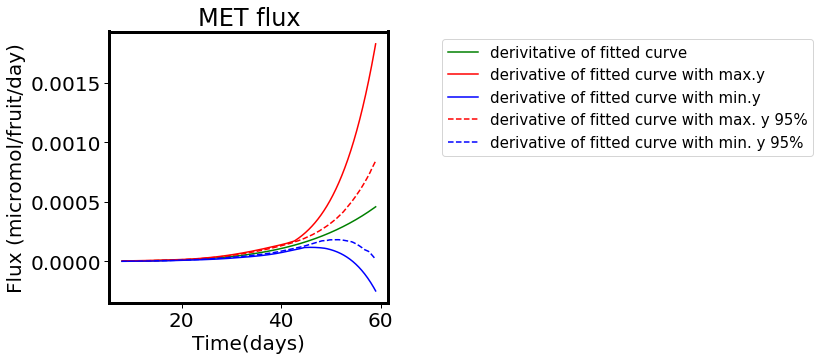

Processing PHE...


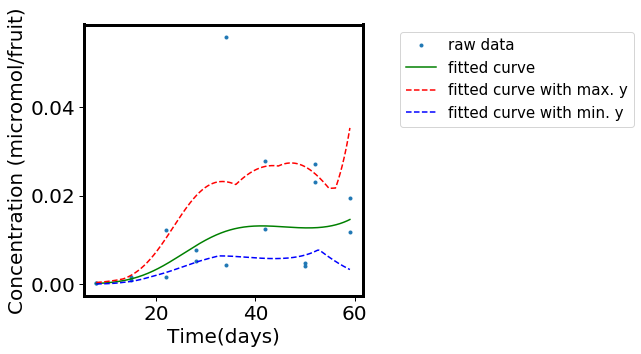

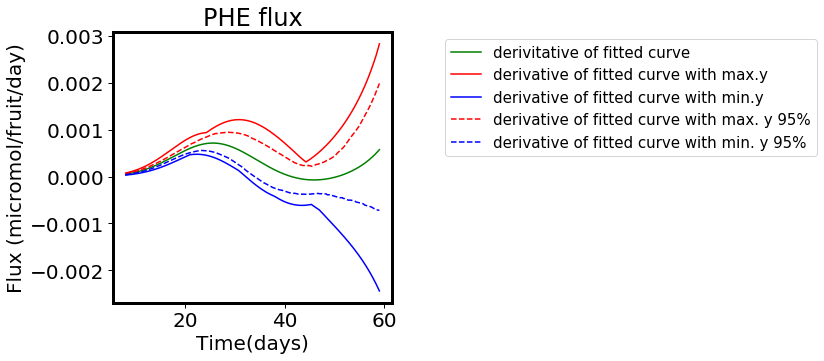

Processing PRO...


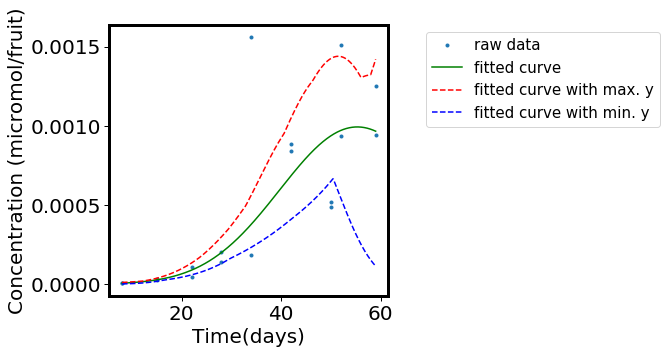

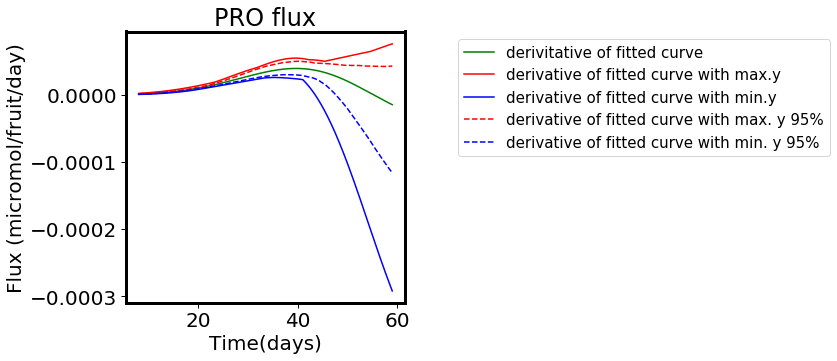

Processing SER...


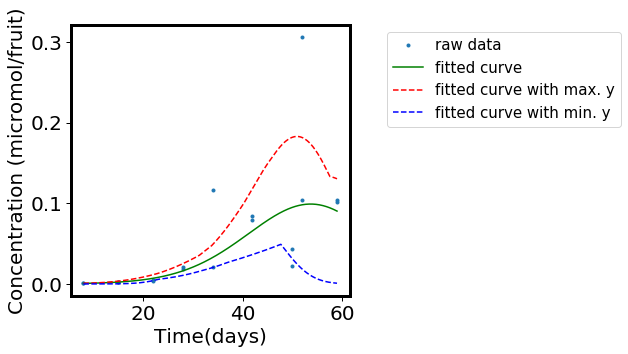

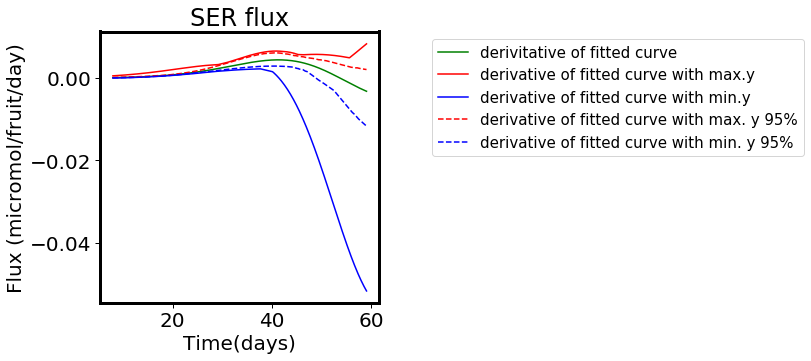

Processing THR...


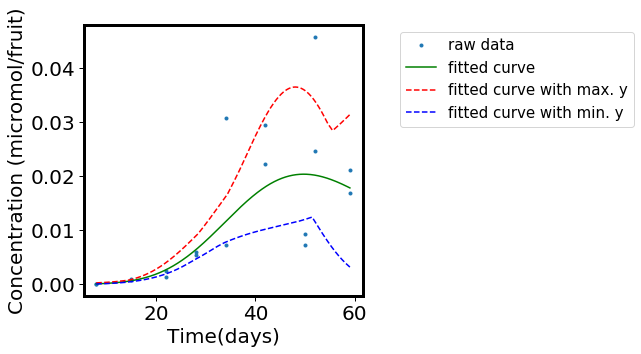

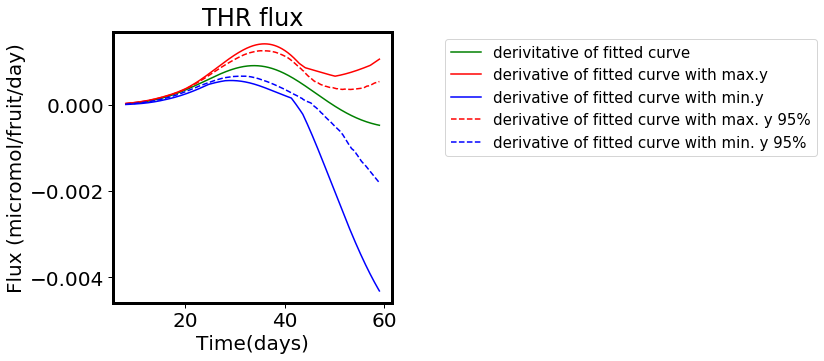

Processing TRP...


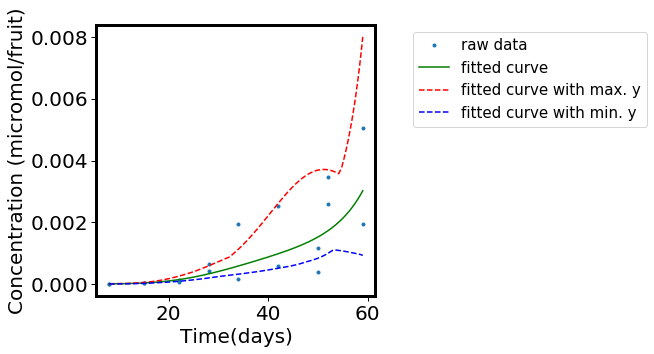

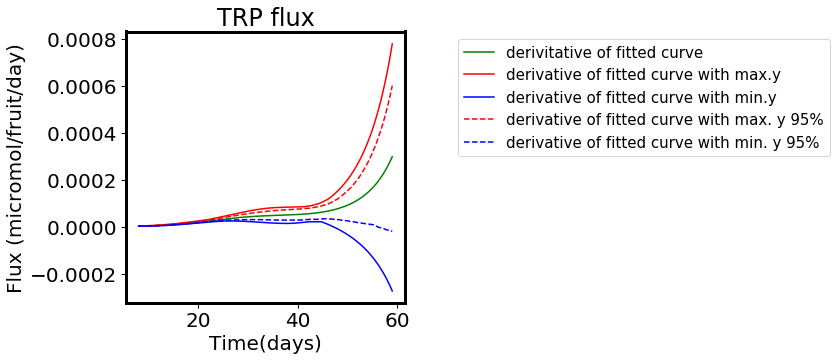

Processing TYR...


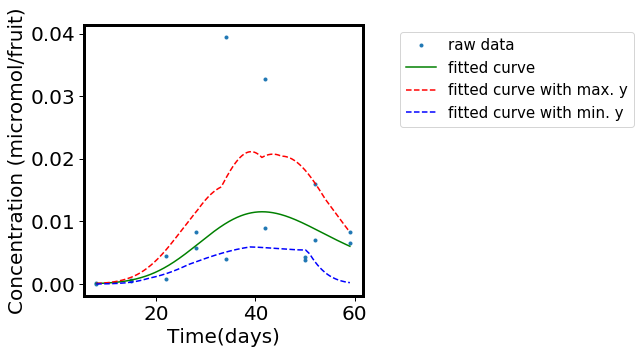

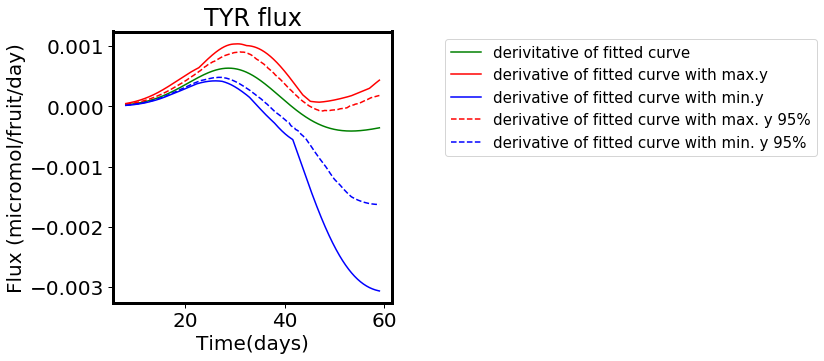

Processing VAL...


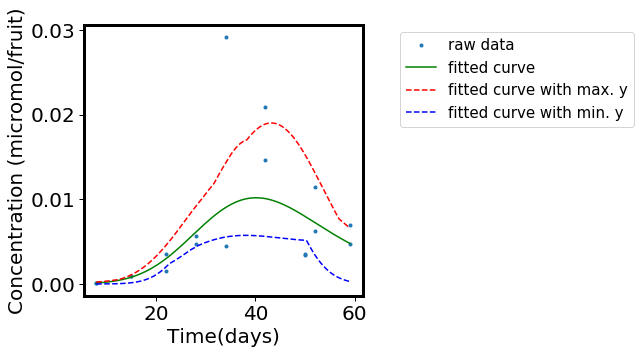

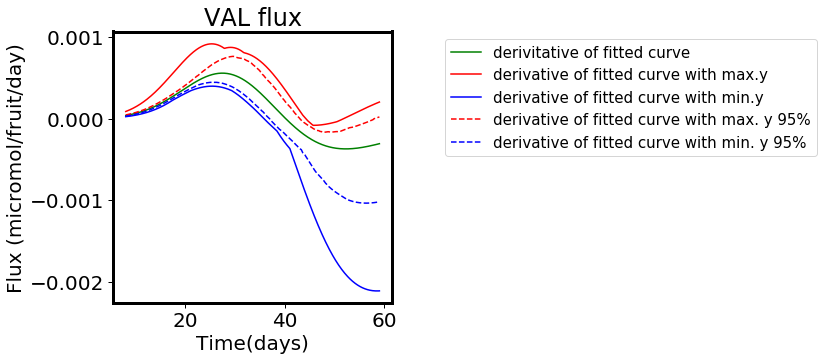

Processing FUM...


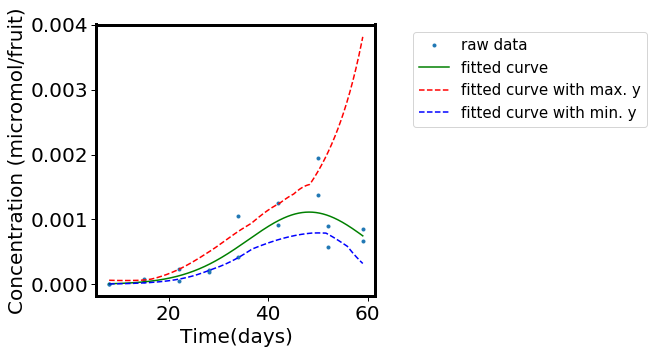

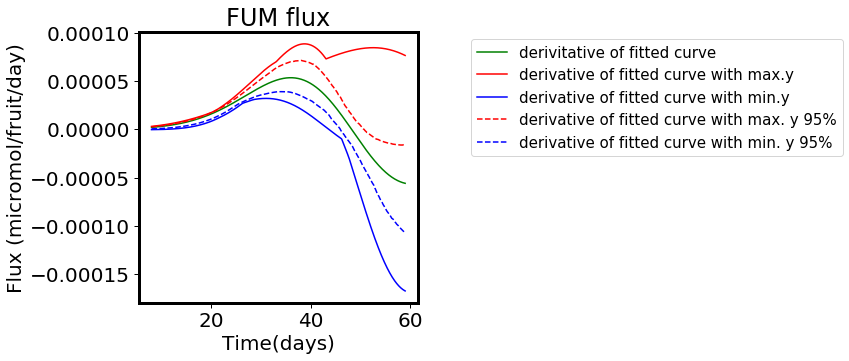

Processing STARCH...


In [25]:

#Retieve for soluble metabolites
import numpy as np
from studyFunctions import generateBoundsFromBiomass
#Day time points of interest
DAA = [26,27]

mets = ("GLC","FRU","SUC","MAL","CIT","L_ALPHA_ALANINE","ASN","L_ASPARTATE","GABA","GLT","GLN","GLY","ILE","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL","FUM")
#mets = ("GLC",)
dfile="Data/Data_OrganicSolutes.csv"
Nsampl= 1000
Ssampl= 0.80

conc = dict()
conc_min = dict()
conc_max = dict()
flux_max = dict()
flux_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [conc[met],conc_max[met],conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=True,degree=3,Ssampling=Ssampl,start=8,stop=59)


mets = ("STARCH",)
dfile="Data/Data_Starch_Protein.csv"
Nsampl= 1000
Ssampl= 0.80

for met in mets:
  print "Processing "+met+"..."
  [conc[met],conc_max[met],conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=False,degree=3,Ssampling=Ssampl,start=8,stop=59)



In [26]:
import pandas as pd
df = pd.DataFrame(data={"mets":[],"amount":[]})
for met in conc.keys():
    df = df.append({"mets":met,"amount":conc[met][1]-conc[met][0]},ignore_index=True)
df

,amount,mets
0,0.000397,ILE
1,0.003990,SUC
2,0.039066,GLN
3,0.236108,GLC
4,0.000148,GLY
5,0.010235,CIT
6,0.000033,FUM
7,0.031649,GLT
8,0.001792,SER
9,0.000381,LYS


Maintenance costs estimated to be same as in dividing cells

In [27]:
Maint = 9 #mmol/mL

In [28]:


#import sbml file
expanding_model2 = io.sbml.create_cobra_model_from_sbml_file("Models/PlantCoreMetabolism_v1_2_3.xml")

#only glucose as nutrient
expanding_model2.reactions.get_by_id("GLC_tx").upper_bound = 0
expanding_model2.reactions.get_by_id("GLC_tx").lower_bound = 0
expanding_model2.reactions.get_by_id("Sucrose_tx").upper_bound = 0
expanding_model2.reactions.get_by_id("Photon_tx").upper_bound = 0


#update phloem output to represent phloem uptake
temp = expanding_model2.copy()
rxn = temp.reactions.get_by_id("Phloem_output_tx")
#print rxn.reaction
metlist = rxn.metabolites.keys()
for met in metlist:
    if met.id.__contains__("PROTON"):
        continue
    a = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-2*a})
c = rxn.metabolites.get(temp.metabolites.get_by_id("sSUCROSE_b"))
rxn.add_metabolites({temp.metabolites.get_by_id("sSUCROSE_b"):-1*c})
rxn.add_metabolites({temp.metabolites.get_by_id("SUCROSE_c"):c})
rxn.lower_bound = 0
rxn.upper_bound = 1000
#print rxn.reaction
#break
rxn.id = "Phloem_uptake_tx"
temp.reactions._generate_index()

#removed LEU and TRP from phloem because degradation pathway is incomplete and their fraction in 
# phloem is extremely minor
for Met in ["LEU_c","TRP_c","VAL_c","ILE_c","PHE_c","4_AMINO_BUTYRATE_c","TYR_c","GLN_c"]:
    met = temp.metabolites.get_by_id(Met)
    coeff = temp.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    temp.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})

expanding_model2 = temp.copy()

#Setting up maintenance
met=Metabolite("ATPNAPDH_maintenance_constraint")
expanding_model2.reactions.get_by_id("ATPase_tx").add_metabolites({met:-1})
expanding_model2.reactions.get_by_id("NADPHoxc_tx").add_metabolites({met:3})
expanding_model2.reactions.get_by_id("NADPHoxp_tx").add_metabolites({met:3})
expanding_model2.reactions.get_by_id("NADPHoxm_tx").add_metabolites({met:3})
#maintenance from expanding cells
expanding_model2.reactions.get_by_id("ATPase_tx").lower_bound = Maint
expanding_model2.reactions.get_by_id("ATPase_tx").upper_bound = Maint

#Create a Protein_b metabolites
rxn = expanding_model2.reactions.get_by_id("Biomass_tx")
for met in ["Ca_b","K_b","Mg_b"]:
    met = expanding_model2.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
formula_dict = rxn.check_mass_balance()
met.formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
met.charge = formula_dict["charge"]*-1
rxn.add_metabolites({met:1})


In [29]:

cellulose1 = celluloseLevels(Vcell1,Ncells)
cellulose2 = celluloseLevels(Vcell2,Ncells)
cellulose_acc = (cellulose2 - cellulose1)/10**6

lipid1 = phospholipidLevels(Vcell1,Ncells)
lipid2 = phospholipidLevels(Vcell2,Ncells)
lipid_acc = (lipid2 - lipid1)/10**6

ProteinConc = 2.5*(10**6)                             # unit = proteins/um3
ProteinConc = ProteinConc*(10**18)                    # unit = proteins/m3
Avagadro_N = 6*(10**23)
ProteinConc = ProteinConc*(1.0/Avagadro_N)            # unit = mol/m3
protein1 = estimateProteinContent(Vcell1,Ncells,ProteinConc)
protein2 = estimateProteinContent(Vcell2,Ncells,ProteinConc)
protein_acc = (protein2 - protein1)/10**6

#Add expanding cell biomass drain
rxn = Reaction("Biomass_expanding_cell")
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("Cellulose_b"):-1*cellulose_acc})
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1*lipid_acc})
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("Protein_b"):-1*protein_acc})
expanding_model2.add_reaction(rxn)
rxn.lower_bound = 1
rxn.upper_bound = 1

In [30]:
#Setting up osmotic constraints
soluteTranslate={"GABA":"4_AMINO_BUTYRATE","SUC":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL",
                 "sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT",
                 "sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}
VO = Metabolite("VO",name="vacuolar osmolytes")
VC = Metabolite("VC",name="vacuolar charge")
CO = Metabolite("CO",name="cytosolic osmolytes")
CC = Metabolite("CC",name="cytosolic charge")

rxn = Reaction("soluble_biomass")
expanding_model2.add_reaction(rxn)
for met2 in df["mets"]:
    if met2 == "STARCH":
        continue
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    METB = Metabolite(met+"_b")
    if met=="HIS":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="MAL":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.7,aMETV:-0.3,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="CIT":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.5,aMETV:-0.5,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="FUM":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.92,aMETV:-0.08,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    ##############
    METC = expanding_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    rxn = expanding_model2.reactions.get_by_id("soluble_biomass")
    rxn.add_metabolites({METB:-1*float(df["amount"][df["mets"]==met2])})

for met in ["NITRATE","AMMONIUM","MGII","KI","CAII"]:
    METB = Metabolite(met+"_b")
    METV = expanding_model2.metabolites.get_by_id(met+"_v")
    rxn = Reaction(met+"_v_biomass")
    rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    METC = expanding_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    rxn = Reaction(met+"_b_biomass")
    rxn.add_metabolites({METB:-1})
    expanding_model2.add_reaction(rxn)

rxn = Reaction("VacCytRatio")
WO = Metabolite("TotalSolute")
rxn.add_metabolites({CO:-1,VO:-1*(Vv/Vc),WO:1+(Vv/Vc)})
rxn.lower_bound = 0
rxn.upper_bound = 1000
expanding_model2.add_reaction(rxn)

C_cell = 275           #Almeida and Huber 1999; units = mOsmol/kg ~ mmol/L
C_cell = 275           #units = mol/m3

rxn = Reaction("TotalSoluteConstraint")
rxn.add_metabolites({WO:-1})
rxn.lower_bound = (C_cell*Vcell2*Ncells - C_cell*Vcell1*Ncells)
rxn.upper_bound = (C_cell*Vcell2*Ncells - C_cell*Vcell1*Ncells)
expanding_model2.add_reaction(rxn)

In [31]:
expanding_model2.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient=0
expanding_model2.reactions.get_by_id("soluble_biomass").objective_coefficient=1
expanding_model2.reactions.get_by_id("GLC_tx").objective_coefficient=0

solution = flux_analysis.parsimonious.pfba(expanding_model2)
print("Minimal Phloem uptake rate = "+str(expanding_model2.reactions.get_by_id("Phloem_uptake_tx").x)+" mol/m3")
print("Minimal Phloem uptake rate = "+str(expanding_model2.reactions.get_by_id("Phloem_uptake_tx").x*totC*12)+" gC/L")


Minimal Phloem uptake rate = 0.338890126216 mol/m3
Minimal Phloem uptake rate = 40.0638648971 gC/L


In [32]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"ExpandingFluxes_PhloemInput.csv",expanding_model2)

#### Data to generate flux map

In [33]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c",
        "SUCROSE_v","FRU_c","FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c",
        "GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c","PHOSPHO_ENOL_PYRUVATE_p",
        "PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = expanding_model2.metabolites.get_by_id(met)
    R = expanding_model2.reactions.get_by_id("Phloem_uptake_tx")
    Cnum_std = totC
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
Phloem_uptake_tx	0.506519864065
GLC_PROTON_rev_vc	-0.0193317938888
GLUCOKIN_RXN_c	-0.487188070176
-----
GLC_p
-----
GLC_6_P_c
G6P_Pi_pc	8.71419936847
PGLUCISOM_RXN_c	3.55266455568
GLUCOKIN_RXN_c	0.487188070176
GLU6PDEHYDROG_RXN_c	-17.5295956121
PHOSPHOGLUCMUT_RXN_c	4.77554361781
-----
GLC_6_P_p
GLU6PDEHYDROG_RXN_p	-8.778097456
PHOSPHOGLUCMUT_RXN_p	-0.0372987876682
G6P_Pi_pc	-8.71419936847
PGLUCISOM_RXN_p	17.5295956121
-----
Cellulose_b
Cellulose_biomass	0.32068923632
AraCore_Biomass_tx	-0.265072644362
Biomass_expanding_cell	-0.0556165919581
-----
SUCROSE_c
sSUCROSE_biomass	-0.0142209788644
SUCROSE_SYNTHASE_RXN_c	-10.307283158
Phloem_uptake_tx	10.7092771245
SUCROSE_PROTON_vc	-0.387772987608
-----
SUCROSE_v
SUCROSE_PROTON_vc	0.387772987608
SUCROSE_v_biomass	-0.00708741655346
3_PERIOD_2_PERIOD_1_PERIOD_48_RXN_v	-0.380685571054
-----
FRU_c
SUCROSE_SYNTHASE_RXN_c	5.15364157901
Phloem_uptake_tx	0.578879844646
FRUCTOKINASE_RXN_c	-5.73252142365
-----
FRU_v
3_PERIOD_2_PERIOD_1_PERIO

In [34]:
R = expanding_model2.reactions.get_by_id("Phloem_uptake_tx")
Cnum_std = totC
for rxn in expanding_model2.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([expanding_model2.metabolites.get_by_id("CC"),
                                        expanding_model2.metabolites.get_by_id("VC"),
                                        expanding_model2.metabolites.get_by_id("VO"),
                                        expanding_model2.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
ILE_b
soluble_biomass	-0.000352402780907
ILE_v_biomass	0.000352402780907
-----
SUCROSE_b
SUCROSE_v_biomass	0.00708741655346
soluble_biomass	-0.00708741655346
-----
GLN_b
soluble_biomass	-0.0289104320119
GLN_v_biomass	0.021594514551
GLN_c_biomass	0.00731591746098
-----
GLC_b
soluble_biomass	-0.209674579416
GLC_v_biomass	0.209674579416
-----
GLY_b
soluble_biomass	-4.37069226745e-05
GLY_c_biomass	4.37069226745e-05
-----
CIT_b
soluble_biomass	-0.0090891977269
CIT_v_biomass	0.0090891977269
-----
FUM_b
soluble_biomass	-1.98071713245e-05
-----
GLT_b
soluble_biomass	-0.0234212449033
GLT_c_biomass	0.0234212449033
-----
SER_b
soluble_biomass	-0.000795490810657
SER_v_biomass	0.000795490810657
-----
LYS_b
soluble_biomass	-0.000338239580688
LYS_v_biomass	0.000338239580688
-----
PRO_b
soluble_biomass	-1.56982096908e-05
-----
L_ASPARTATE_b
soluble_biomass	-0.000395014476209
L_ASPARTATE_c_biomass	0.000395014476209
-----
ASN_b
soluble_biomass	-0.000374719642224
ASN_c_biomass	0.000374719642224
---

### When organic content maximized and SOF is minimized

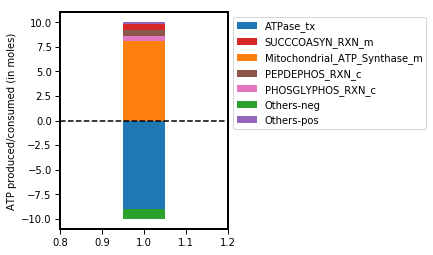

In [35]:
from studyFunctions import writeSolutionFluxesToFile

generateATPbudget(expanding_model2,solution.fluxes,outfile="ATPbudget_expanding26_max.csv",
                  show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

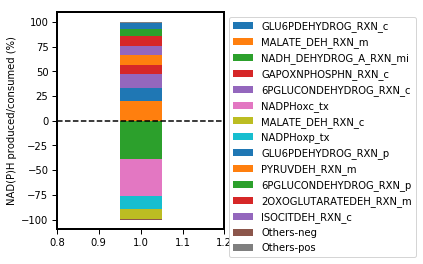

In [36]:
from studyFunctions import writeSolutionFluxesToFile

generateNADHNADPHbudget(expanding_model2,solution.fluxes,outfile="NADPHbudget_expanding26_max",
                        show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

### When SOF is minimized

In [37]:
model = expanding_model2.copy()
model.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient=1
model.reactions.get_by_id("soluble_biomass").objective_coefficient=0
model.reactions.get_by_id("GLC_tx").objective_coefficient=0

solution = flux_analysis.parsimonious.pfba(model)
print("Minimal Phloem uptake rate = "+str(expanding_model2.reactions.get_by_id("Phloem_uptake_tx").x)+" mol/m3")
#print("Minimal Phloem uptake rate = "+str(expanding_model2.reactions.get_by_id("Phloem_uptake_tx").x*expanding_model2.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")


Minimal Phloem uptake rate = 0.338890126216 mol/m3


In [38]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"ExpandingFluxes_minSOF_PhloemInput.csv",model)

#### Data to generate flux map

In [39]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c",
        "SUCROSE_v","FRU_c","FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c",
        "GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c","PHOSPHO_ENOL_PYRUVATE_p",
        "PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = model.metabolites.get_by_id(met)
    R = expanding_model2.reactions.get_by_id("Phloem_uptake_tx")
    Cnum_std = totC
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
Phloem_uptake_tx	0.484307993134
GLUCOKIN_RXN_c	-0.484307993134
-----
GLC_p
-----
GLC_6_P_c
GLU6PDEHYDROG_RXN_c	-17.5403065547
G6P_Pi_pc	8.72233134305
PHOSPHOGLUCMUT_RXN_c	4.74920675811
GLUCOKIN_RXN_c	0.484307993134
PGLUCISOM_RXN_c	3.58446046039
-----
GLC_6_P_p
PGLUCISOM_RXN_p	17.5403065547
GLU6PDEHYDROG_RXN_p	-8.78232728164
G6P_Pi_pc	-8.72233134305
PHOSPHOGLUCMUT_RXN_p	-0.0356479299958
-----
Cellulose_b
Biomass_expanding_cell	-0.0556165919581
AraCore_Biomass_tx	-0.253340434388
Cellulose_biomass	0.308957026346
-----
SUCROSE_c
SUCROSE_SYNTHASE_RXN_c	-10.2260631573
sSUCROSE_biomass	-0.0135915532575
Phloem_uptake_tx	10.2396547106
-----
SUCROSE_v
-----
FRU_c
SUCROSE_SYNTHASE_RXN_c	5.11303157866
Phloem_uptake_tx	0.553494849296
FRUCTOKINASE_RXN_c	-5.66652642795
-----
FRU_v
-----
FRUCTOSE_6P_c
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c	4.49033411811
6PFRUCTPHOS_RXN_c	-6.57240008567
FRUCTOKINASE_RXN_c	5.66652642795
PGLUCISOM_RXN_c	-3.58446046039
-----
GLYCEROL_3P_c
GLYCEROL_3P_pc	-0.001587

In [40]:
R = expanding_model2.reactions.get_by_id("Phloem_uptake_tx")
Cnum_std = totC
for rxn in model.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([model.metabolites.get_by_id("CC"),
                                        model.metabolites.get_by_id("VC"),
                                        model.metabolites.get_by_id("VO"),
                                        model.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
ILE_b
-----
SUCROSE_b
-----
GLN_b
-----
GLC_b
-----
GLY_b
-----
CIT_b
-----
FUM_b
-----
GLT_b
-----
SER_b
-----
LYS_b
-----
PRO_b
-----
L_ASPARTATE_b
-----
ASN_b
-----
L_ALPHA_ALANINE_b
-----
VAL_b
-----
THR_b
-----
FRU_b
-----
TRP_b
-----
PHE_b
-----
MET_b
-----
MAL_b
-----
TYR_b
-----
4_AMINO_BUTYRATE_b
-----
NITRATE_b
NITRATE_b_biomass	-0.0462358869146
NITRATE_v_biomass	0.0418556207223
NITRATE_c_biomass	0.00438026619234
-----
AMMONIUM_b
AMMONIUM_b_biomass	-0.0462358869146
AMMONIUM_v_biomass	0.0418556207223
AMMONIUM_c_biomass	0.00438026619234
-----
MGII_b
-----
KI_b
-----
CAII_b


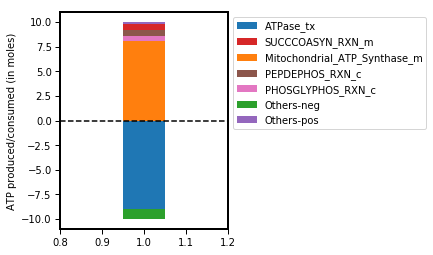

In [41]:
from studyFunctions import generateATPbudget

generateATPbudget(expanding_model2,solution.fluxes,outfile="ATPbudget_expandingCells_minSOF.csv",
                  show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

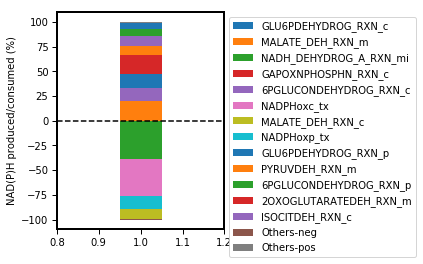

In [42]:
from studyFunctions import generateATPbudget

generateNADHNADPHbudget(expanding_model2,solution.fluxes,outfile="NADPHbudget_expandingCells_minSOF",
                        show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

### Estiamting ATP cost of protein, lipid and cellulose biosynthesis

In [43]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("Protein_b"):-1})
rxn.lower_bound = expanding_model2.reactions.get_by_id("Biomass_tx").x
rxn.upper_bound = expanding_model2.reactions.get_by_id("Biomass_tx").x
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("protein")
temp_model3.reactions.get_by_id("ATPase_tx").x

protein


-0.006238889227999668

In [44]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0

#removed AA from phloem because their degradation pathway is incomplete and their fraction in 
# phloem is relatively minor
for Met in ["HIS_c",]:
    met = temp_model3.metabolites.get_by_id(Met)
    coeff = temp_model3.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    temp_model3.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})
#Add NH4 and SO4 escape mechanism
temp_model3.reactions.NH4_ec.lower_bound = -1000
temp_model3.reactions.SO4_ec.lower_bound = -1000

rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1})
rxn.lower_bound = expanding_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
rxn.upper_bound = expanding_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("lipid")
temp_model3.reactions.get_by_id("ATPase_tx").x

lipid


-0.0038090921486890437

In [45]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0

#removed AA from phloem because their degradation pathway is incomplete and their fraction in 
# phloem is relatively minor
for Met in ["HIS_c","MET_c"]:
    met = temp_model3.metabolites.get_by_id(Met)
    coeff = temp_model3.reactions.get_by_id("Phloem_uptake_tx").metabolites.get(met)
    temp_model3.reactions.get_by_id("Phloem_uptake_tx").add_metabolites({met:-1*coeff})
#Add NH4 and SO4 escape mechanism
temp_model3.reactions.NH4_ec.lower_bound = -1000
temp_model3.reactions.SO4_ec.lower_bound = -1000


rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("Cellulose_b"):-1})
rxn.lower_bound = abs(expanding_model2.reactions.get_by_id("Cellulose_biomass").x)
rxn.upper_bound = abs(expanding_model2.reactions.get_by_id("Cellulose_biomass").x)
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("cellulose")
temp_model3.reactions.get_by_id("ATPase_tx").x

cellulose


-0.025892465464046274